In [18]:
import torch
from torch import nn
from tqdm.auto import tqdm
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import MNIST,OxfordIIITPet
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display


# Generator & Critic

In [19]:
class Generator(nn.Module):
    def __init__(self, z_dim=10,im_ch=1,hidden_dim=1024):
        super(Generator,self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(

            self.conv_block(z_dim,hidden_dim,kernel_size=4,stride=1,),
            self.conv_block(hidden_dim,hidden_dim//2,kernel_size=4,stride=2,padding=1),
            self.conv_block(hidden_dim//2,hidden_dim//4,kernel_size=4,stride=2,padding=1),
            self.conv_block(hidden_dim//4,hidden_dim//8,kernel_size=4,stride=2,padding=1),
            self.conv_block(hidden_dim//8,hidden_dim//16,kernel_size=4,stride=2,padding=1),
            # self.conv_block(hidden_dim//16,hidden_dim//32,kernel_size=4,stride=2,padding=1),
            self.conv_block(hidden_dim//16,im_ch,kernel_size=4,stride=2,padding=1,final_layer=True)
        )

    def conv_block(self,input_ch,output_ch,kernel_size=3,stride=2,padding=0,final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_ch,out_channels=output_ch,kernel_size=kernel_size,stride=stride,padding=padding),
                nn.BatchNorm2d(num_features=output_ch),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_ch,out_channels=output_ch,kernel_size=kernel_size,stride=stride,padding=padding),
                nn.Tanh()
            )
        
    def unsqueeze_noise(self,noise):
        return noise.view(len(noise),self.z_dim,1,1)
    
    def forward(self,noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

In [20]:
class Critic(nn.Module):
    def __init__(self,im_ch=1,hidden_dim=32):
        super(Critic,self).__init__()
        self.crit = nn.Sequential(
            self.conv_block(im_ch,hidden_dim,kernel_size=4,stride=2,padding=1),
            self.conv_block(hidden_dim,hidden_dim*2,kernel_size=4,stride=2,padding=1),
            self.conv_block(hidden_dim*2,hidden_dim*4,kernel_size=4,stride=2,padding=1),
            self.conv_block(hidden_dim*4,hidden_dim*8,kernel_size=4,stride=2,padding=1),
            self.conv_block(hidden_dim*8,hidden_dim*16,kernel_size=4,stride=2,padding=1),
            # self.conv_block(hidden_dim*16,hidden_dim*32,kernel_size=4,stride=2,padding=1),
            self.conv_block(hidden_dim*16,1,final_layer=True)
        )
        
    def conv_block(self,in_ch,out_ch,kernel_size=4,stride=1,padding=0,final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=kernel_size,stride=stride,padding=padding),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(negative_slope=0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=kernel_size,stride=stride,padding=padding)
            )
    def forward(self,image):
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred),-1)

# Preprocess

In [21]:
def get_noise(n_sample,z_dim,device='cpu'):
    noise = torch.randn(n_sample,z_dim,device=device)
    return noise

In [22]:
n_epochs = 50
z_dim = 128
display_step = 100
batch_size = 128
# lr = 0.0002
lr = 0.001
beta_1 = 0.5
beta_2 = 0.999
c_lamda = 10
crit_repeats = 5
device = 'cuda'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

])

dataset = datasets.ImageFolder(root='/mnt/d/ML_playground/Learn_GAN/when-I-learn-GAN/ANI-WGAN/anime', 
                               transform=transform)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

gen = Generator(z_dim,im_ch=3).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic(im_ch=3).to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)


### Image Visualization

In [23]:
def show_tensor_img(img_tensor,num_imgs=25,size=(1,28,28),epoch=0):
    img_tensor=(img_tensor+1)/2
    img_unflat = img_tensor.detach().cpu()
    img_unflat = img_unflat.expand(-1, 3, -1, -1)
    img_grid = make_grid(img_unflat[:num_imgs],nrow=5)
    plt.imshow(img_grid.permute(1,2,0).squeeze())
    plt.axis('off')
    # plt.savefig(f'/content/drive/MyDrive/ANI_WGAN/ani_gen/epoch_{epoch}.jpg', format='jpg')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


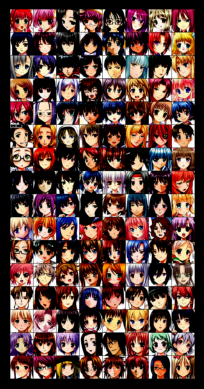

In [24]:
batch_images, _ = next(iter(dataloader))

def show_sample_images(images):
    plt.rcParams['figure.facecolor'] = 'black'
    grid_img = torchvision.utils.make_grid(images, nrow=8)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

show_sample_images(batch_images)


#### Loss calculation

In [25]:
def get_gradient(crit,real,fake,epsilon):
    mixed_imgs = real * epsilon + fake * (1-epsilon)
    mixed_score = crit(mixed_imgs)
    gradient = torch.autograd.grad(
        inputs=mixed_imgs,
        outputs=mixed_score,
        grad_outputs=torch.ones_like(mixed_score),
        create_graph=True,
        retain_graph=True
    )[0]
    return gradient

def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient),-1)
    gradient_norm = gradient.norm(2,dim=1)

    penalty = ((gradient_norm-1)**2).mean()
    
    return penalty

def get_gen_loss(crit_fake_pred):
    gen_loss = -crit_fake_pred.mean()

    return gen_loss

def get_crit_loss(crit_fake_pred,crit_real_pred,gp,c_lambda):
    crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + (c_lambda*gp)

    return crit_loss

### Training Visualization

In [26]:
def plotlosses(generator_losses,critic_losses):
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(4, 3))
    fontsize=6
    ticksize=6
    ax.plot(generator_losses, label='Generator Loss')
    ax.plot(critic_losses, label='Critic Loss')
    ax.set_xlabel('Step',fontsize =fontsize)
    ax.set_ylabel('Loss',fontsize=fontsize)
    ax.set_title('GAN Training Loss')
    ax.tick_params(axis='both', which='major', labelsize=ticksize)
    ax.legend(fontsize=fontsize)
    plt.show()

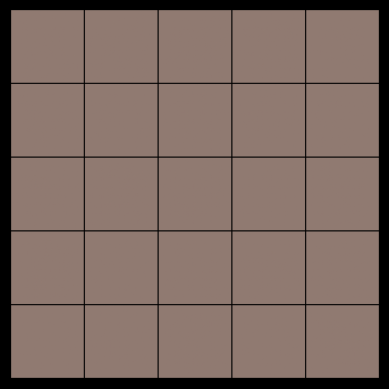

In [27]:
import os 

test_noise = get_noise(25,z_dim,device=device)
show_tensor_img(gen(test_noise),epoch='init')

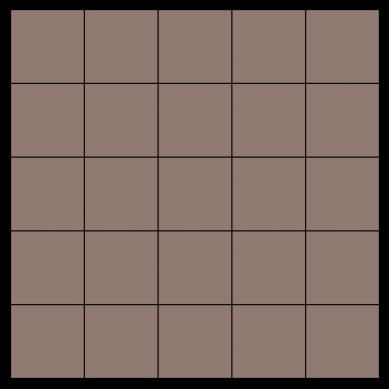

In [28]:
test_noise = torch.load('/mnt/d/ML_playground/Learn_GAN/when-I-learn-GAN/ANI-WGAN/test_noise_ani/test_noise.pt')
show_tensor_img(gen(test_noise),epoch='init')

# Train

### Load Checkpoint
(optional)

In [29]:
gen_cur_step  = 0
crit_cur_step = 0
generator_losses =[]
critic_losses = []
total_step = 0

checkpoint = torch.load('/mnt/d/ML_playground/Learn_GAN/when-I-learn-GAN/ANI-WGAN/checkpoint/weight_best.pt')

gen = Generator(z_dim,im_ch=3).to(device)
gen.load_state_dict(checkpoint['gen_state_dict'])
crit = Critic(im_ch=3).to(device)
crit.load_state_dict(checkpoint['crit_state_dict'])
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))
gen_opt.load_state_dict(checkpoint['gen_opt_state_dict'])
crit_opt.load_state_dict(checkpoint['crit_opt_state_dict'])
generator_losses = checkpoint['generator_losses']
critic_losses = checkpoint['critic_losses']
last_epoch = checkpoint['epoch']
crit_cur_step = checkpoint['crit_cur_step']
gen_cur_step = checkpoint['gen_cur_step']
lr = checkpoint['lr']
gen_opt.param_groups[0]['lr'] = lr
crit_opt.param_groups[0]['lr'] = lr


### Training

In [ ]:
for epoch in range(last_epoch+1,n_epochs):
    cur_lr = gen_opt.param_groups[0]['lr']
    mean_generator_loss = 0
    total_step = 0
    if epoch == 10 :
        lr = 0.0005
        gen_opt.param_groups[0]['lr'] = lr
        crit_opt.param_groups[0]['lr'] = lr
    if epoch == 25 :
        lr = 0.0002
        gen_opt.param_groups[0]['lr'] = lr
        crit_opt.param_groups[0]['lr'] = lr

    for real,_ in tqdm(dataloader):
        cur_lr = gen_opt.param_groups[0]['lr']
        total_step += 1
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size,z_dim,device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)
            epsilon = torch.rand(len(real),1,1,1,device=device,requires_grad=True)
            gradient = get_gradient(crit,real,fake.detach(),epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred,crit_real_pred,gp,c_lamda)

            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            crit_loss.backward(retain_graph = True)
            crit_opt.step()
            crit_cur_step+=1
        critic_losses += [mean_iteration_critic_loss]


        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size,z_dim,device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)

        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()
        gen_opt.step()
        gen_cur_step+=1
        generator_losses +=[gen_loss.item()]
        mean_generator_loss += gen_loss.item() /total_step
        
    checkpoint = {
    'epoch': epoch,
    'gen_cur_step': gen_cur_step,
    'crit_cur_step': crit_cur_step,
    'gen_state_dict': gen.state_dict(),
    'gen_opt_state_dict': gen_opt.state_dict(),
    'crit_state_dict': crit.state_dict(),
    'crit_opt_state_dict': crit_opt.state_dict(),
    'generator_losses': generator_losses,
    'critic_losses': critic_losses,
    'z_dim' :z_dim,
    'batch_size' : batch_size,
    'lr' : lr,
    'beta_1':beta_1,
    'beta_2': beta_2,
    'c_lamda':c_lamda,
    'crit_repeats' : crit_repeats,
    'device' :  device
    }
    
    checkpoint_path = '/mnt/d/ML_playground/Learn_GAN/when-I-learn-GAN/ANI-WGAN/checkpoint'
    torch.save(checkpoint, checkpoint_path)
    
    print(f'Epoch {epoch},lr {cur_lr}, gen_step {gen_cur_step}, crit_step {crit_cur_step} Generator loss: {mean_generator_loss} Critic loss: {mean_iteration_critic_loss}')
    test = gen(test_noise)
    show_tensor_img(test,epoch=epoch)
    plotlosses(generator_losses,critic_losses)

# Test

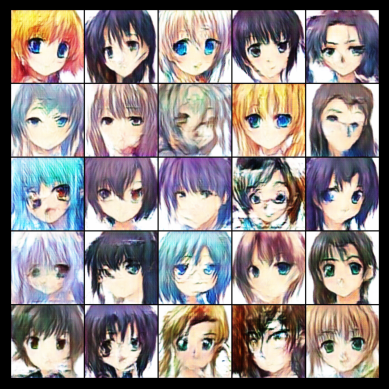

In [30]:
test_noise = get_noise(25,128,device=device)
gen.eval()
pred = gen(test_noise)
show_tensor_img(pred)

In [31]:
def generate_transition_codes(num_codes, latent_dim, num_steps=10,device=device):

    start_codes = torch.randn(num_codes, latent_dim,device=device)

    end_codes = torch.randn(num_codes, latent_dim,device=device)
    transition_codes = []
    for i in range(num_steps):
        alpha = i / (num_steps - 1)  
        intermediate_codes = (1 - alpha) * start_codes + alpha * end_codes
        transition_codes.append(intermediate_codes)

    return torch.cat(transition_codes)

def show_tensor_test_img(img_tensor,num_imgs=25,nrow=5,size=(5,5),epoch=0):
    img_tensor=(img_tensor+1)/2
    img_unflat = img_tensor.detach().cpu()
    img_unflat = img_unflat.expand(-1, 3, -1, -1)
    img_grid = make_grid(img_unflat[:num_imgs],nrow=nrow)
    plt.figure(figsize=size)
    plt.imshow(img_grid.permute(1,2,0).squeeze())
    plt.axis('off')
    plt.show()

def generate_gif(img_ls, save_path):
    img_ls=(img_ls+1)/2
    img_ls=img_ls.detach().cpu()
    img_ls=img_ls.expand(-1, 3, -1, -1)
    transform = transforms.ToPILImage()
    images = [transform(img) for img in img_ls]
    
    # Save the images as a GIF
    images[0].save(save_path, save_all=True, append_images=images[1:], optimize=False, duration=1, loop=0)

    return images

torch.Size([1, 128])


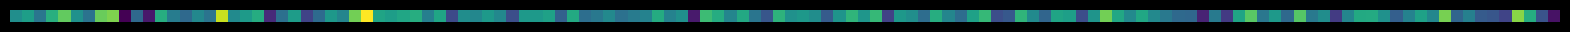

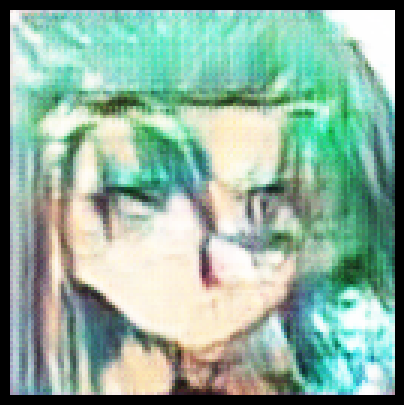

In [32]:
test_noise = get_noise(1,128,device=device)
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(test_noise.cpu().detach().numpy())
print(test_noise.size())
gen.eval()
pred = gen(test_noise)
show_tensor_test_img(pred)

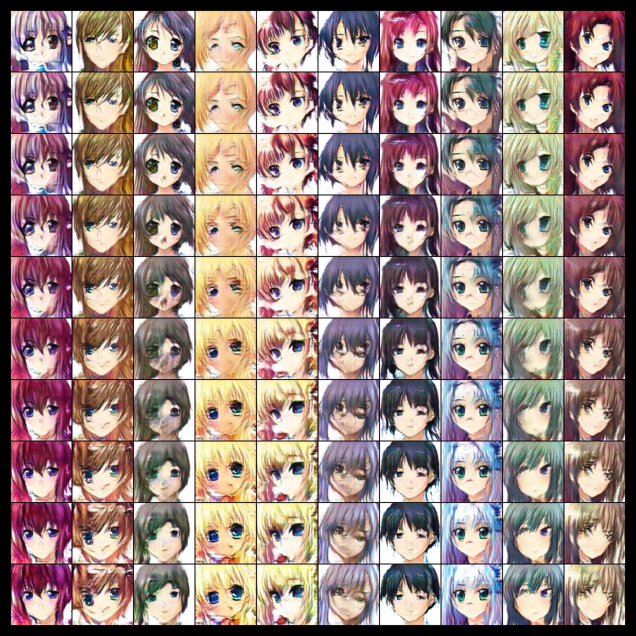

In [39]:
manipulate_test_noise = generate_transition_codes(10,128,num_steps=10,device='cuda')
gen.eval()
pred = gen(manipulate_test_noise)
show_tensor_test_img(pred,num_imgs=100,nrow = 10,size=(8,8))

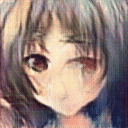

In [52]:
manipulate_test_noise = generate_transition_codes(1,128,num_steps=50,device='cuda')
gen.eval()
pred = gen(manipulate_test_noise)
generate_gif(pred,'manipulated.gif')
display(Image(filename='manipulated.gif'))